# Some source codes of SSW Project by Suji Lee

## 1. Pandas (Some part in progress preparing Data Set)

In [ ]:
# 국가별 방문객 수 데이터 불러오기
visitors_country = pd.read_csv('/content/drive/MyDrive/1. 개인 프로젝트/Raw_Data/Project_SSW/데이터 목록_데이터 원본/제주특별자치도_국적별관광객현황_20201231.csv', engine='python', encoding='CP949')
visitors_country

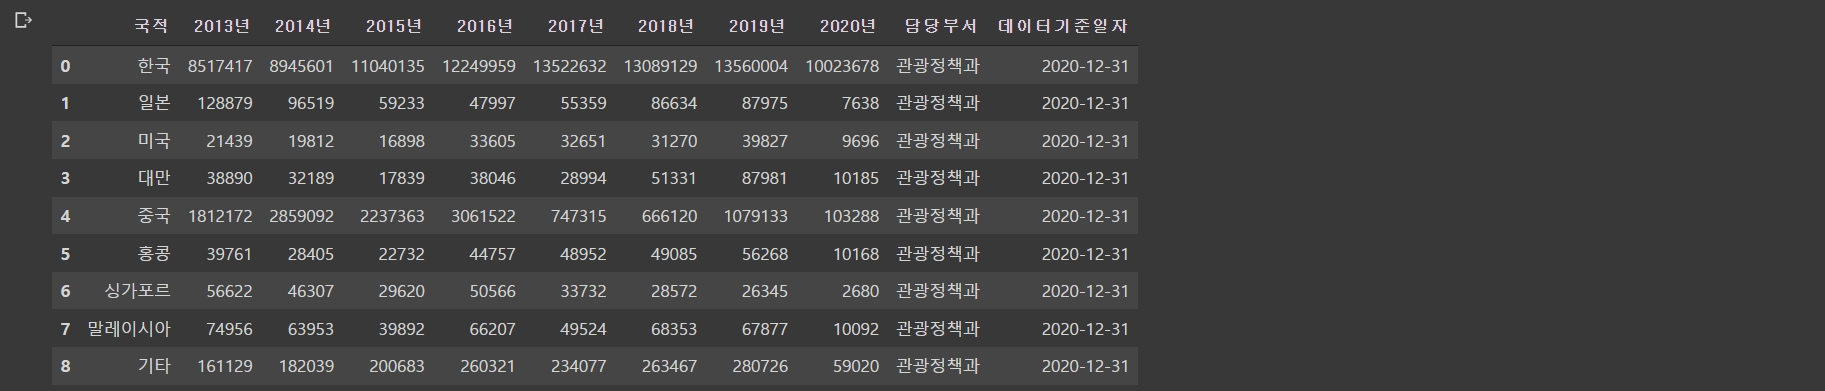

In [ ]:
# 무의미 컬럼 제거
visitors_country=visitors_country.drop(['데이터기준일자','담당부서'], axis=1).copy()
# 분석할 수 있게 Tidy data 형태로 변환
visitors_country_df = pd.melt(visitors_country,["국적"], var_name="년도", value_name="방문객수")
visitors_country_df = visitors_country_df.sort_values(by=["년도"])
visitors_country_df = visitors_country_df[['년도','국적','방문객수']]
visitors_country_df

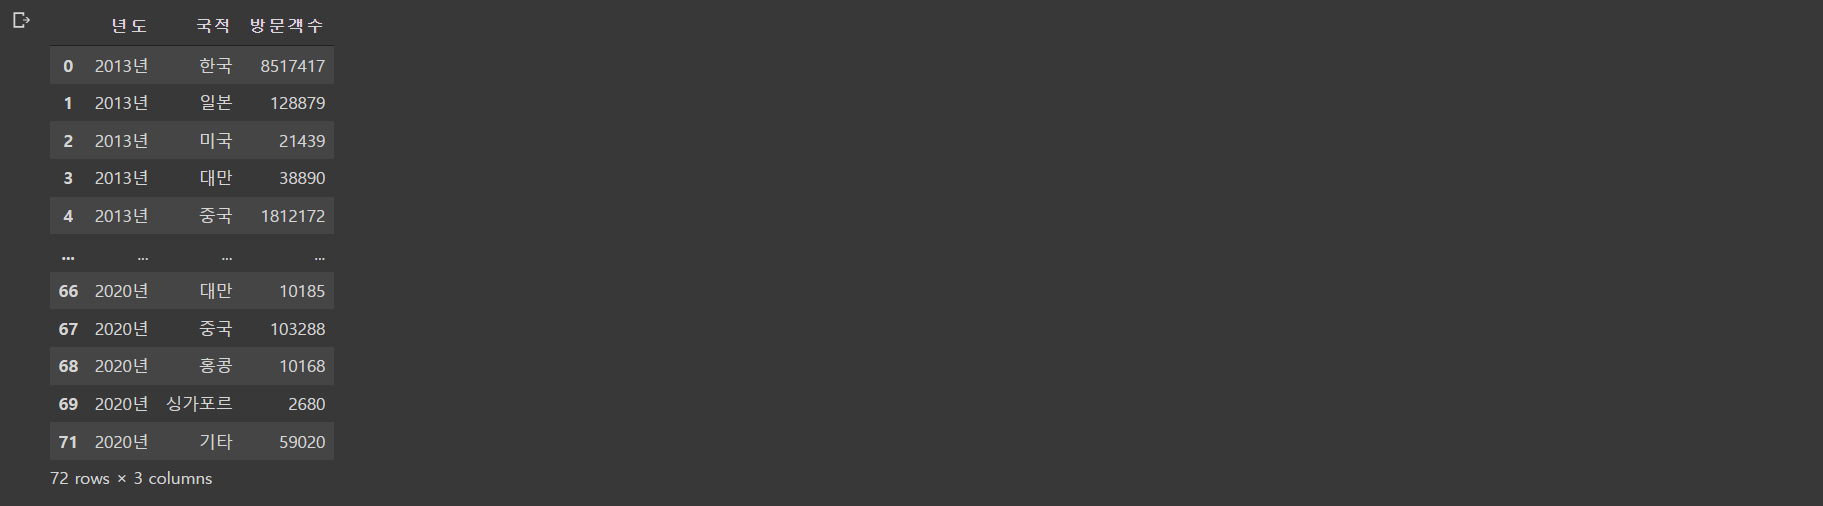

In [ ]:
# 카드 매출액 데이터 불러오기
visitor_spent = pd.read_csv('/content/drive/MyDrive/1. 개인 프로젝트/Raw_Data/Project_SSW/데이터 목록_데이터 원본/제주특별자치도_주제3_상권분석을 위한 유동인구에 따른 카드 매출액 변화 데이터 활용_필터링.csv', engine='python', encoding='CP949')
visitor_spent.head(2)

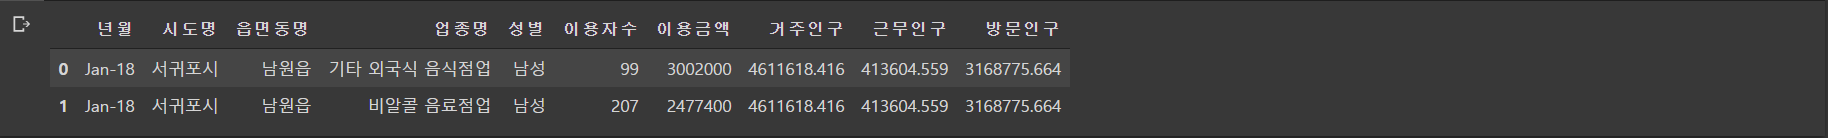

In [ ]:
# 특정 값에 해당하는 데이터만 추출
visitor_spent_hansik = visitor_spent[['년월','읍면동명','업종명','이용금액','이용자수']]
ext = '업종명=="한식 음식점업"'
visitor_spent_hansik_1 = visitor_spent_hansik.query(ext)
visitor_spent_hansik_1

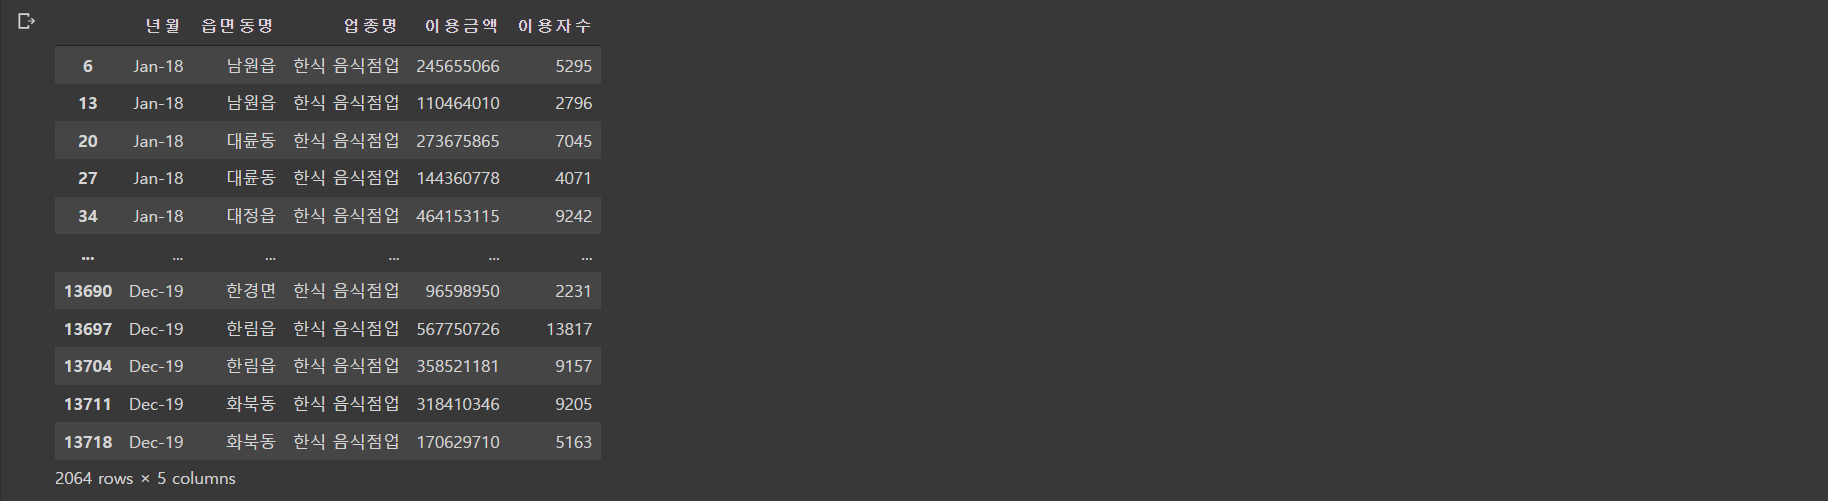

In [ ]:
# 년도와 월 분리해서 새로운 컬럼 추가하기
visitor_spent_hansik_1["연도"]=visitor_spent_hansik_1["년월"].map(lambda x: int(x.split('-')[1]))
# datetime 형식으로 변환
from datetime import datetime
visitor_spent_hansik_1['년월2'] = visitor_spent_hansik_1['년월'].apply(lambda _ : datetime.strptime(_,'%b-%y'))

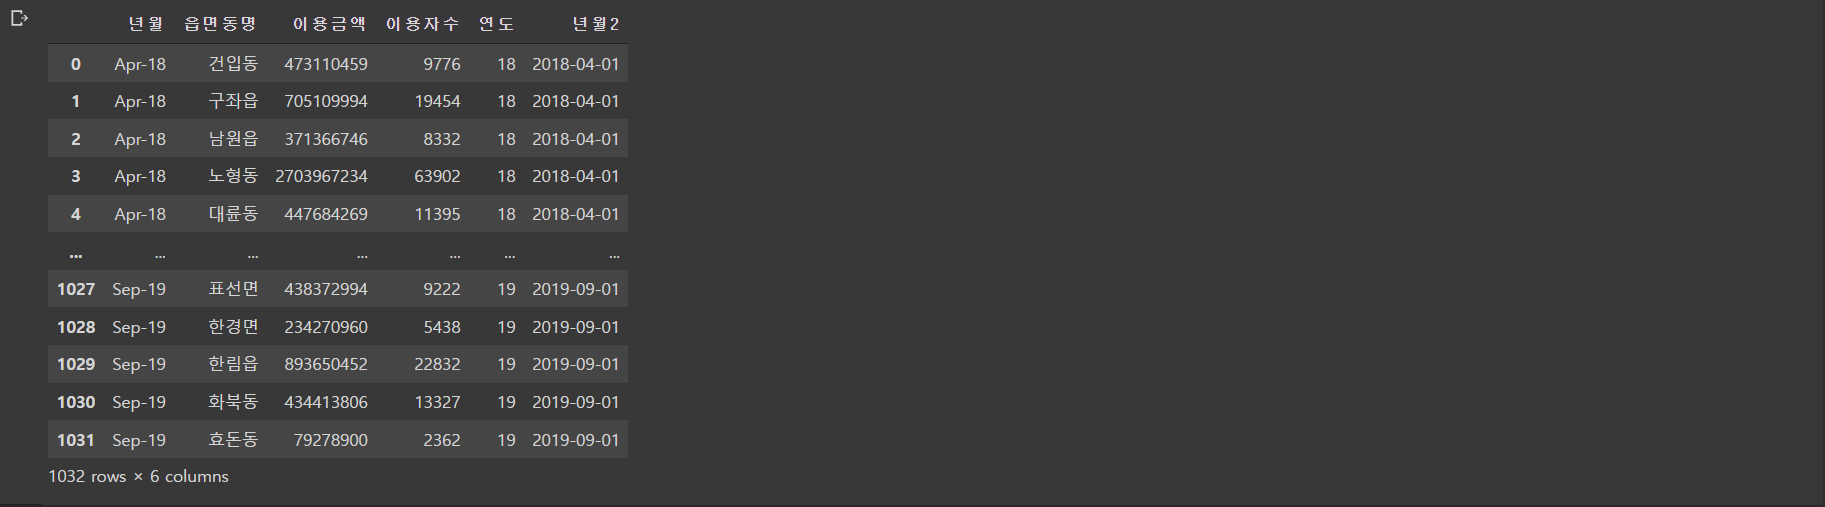

## 2. Modeling

### 1. SARIMAX

In [ ]:
# SARIMAX

import statsmodels.api as sm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings( 'ignore' )

# 모수
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=df_sgps_arimax_holiday.iloc[:,:].이용금액, exog=exog , order=(0, 0, 0), seasonal_order=(0, 0, 0, 12))
iter_cnt = 0

# for 문으로 최소 AIC 찾기 (Grid Search)
import itertools

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(
                endog=df_sgps_arimax_holiday.iloc[:,:].이용금액, 
                exog=exog, 
                order=param,seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            result = tmp_mdl.fit()
            
            print("SARIMAX{}x{}(12), AIC={}".format(param, param_seasonal, result.aic))
            if result.aic < best_AIC:
                best_AIC = result.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = tmp_mdl
        except:
            continue
print("Best SARIMAX{}x{}(12) model,AIC={}".format(best_pdq, best_seasonal_pdq, best_AIC))

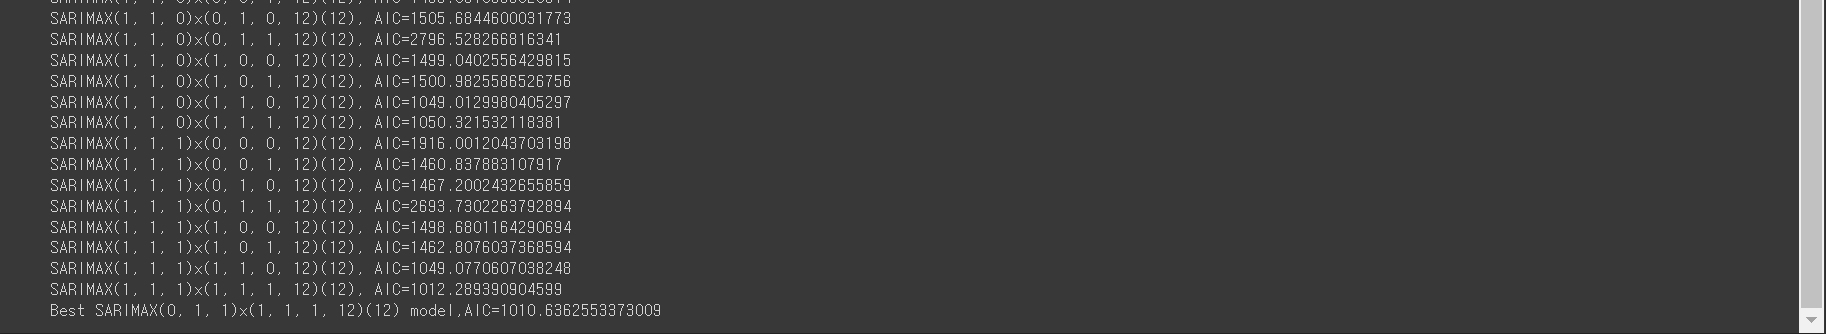

In [ ]:
# train set의 endog(내부변수)와 exog(외부변수) 지정
endog=train.iloc[:, :1]
exog=train.iloc[:, 1:]

# 모델 정의 및 훈련
sarimax_exog_6_model = SARIMAX(endog = endog, order=(0,1,1), seasonal_order=(1,1,1,12), exog = exog)
result = sarimax_exog_6_model.fit(disp=False)

# test set에 대한 예측
pred = result.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=test_exog, dynamic=False)
test_forecast = pred.predicted_mean.round()

# DataFrame에 예측값 추가
result_df = pd.DataFrame(test)
result_df['predicted_value'] = test_forecast
result_df

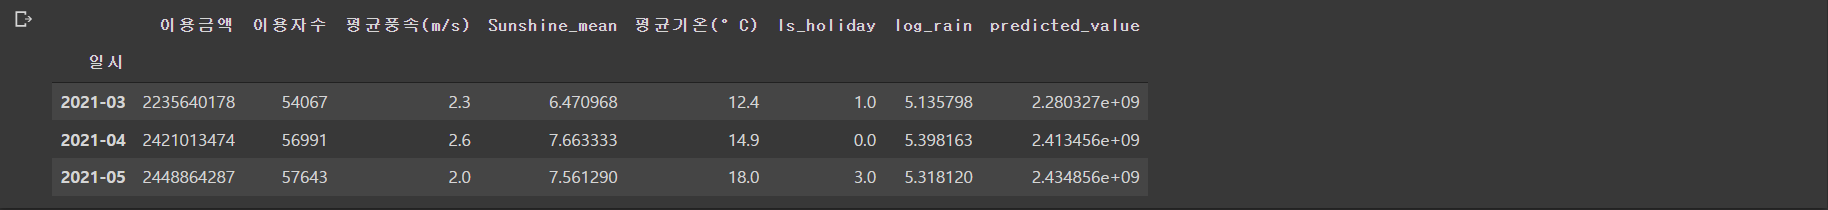

### 2. SARIMA

In [ ]:
# SARIMA

import statsmodels.api as sm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings( 'ignore' )

# train, test set 지정
train = df_sgps_arimax.iloc[0:50, 0:2]
test = df_sgps_arimax.iloc[50:, 0:2]

# 모수
p = range(0, 2)
q = range(0, 2)
d = range(0, 2)
P = range(0, 2)
Q = range(0, 2)
D = range(0, 2)

# 초기화
best_AIC = float("inf")
best_model = sm.tsa.SARIMAX(endog=df_sgps_arimax.iloc[:,:].이용금액, order=(0, 0, 0), seasonal_order=(0, 0, 0, 12))
iter_cnt = 0

# for 문으로 최소 AIC 찾기 (Grid Search)
import itertools

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = SARIMAX(
                endog=df_sgps_arimax.iloc[:,:].이용금액, 
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            result = tmp_mdl.fit()
            
            print("SARIMA{}x{}(12), AIC={}".format(param, param_seasonal, result.aic))
            if result.aic < best_AIC:
                best_AIC = result.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = tmp_mdl
        except:
            continue
print("Best SARIMA{}x{}(12) model,AIC={}".format(best_pdq, best_seasonal_pdq, best_AIC))

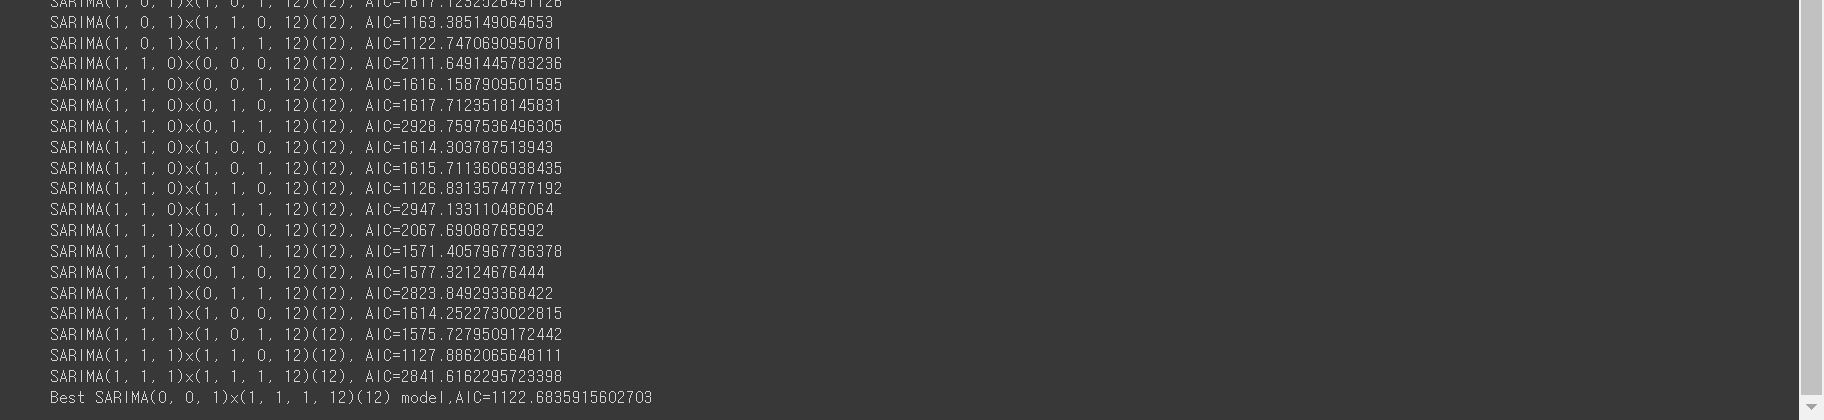

In [ ]:
# SARIMA 모델 정의 및 훈련

sarima_model = SARIMAX(train.이용금액, order=(0,0,1), seasonal_order=(1,1,1,12))
result_ = sarima_model.fit(disp=False)

### 3. ML (Using by Pycaret Library)


In [ ]:
# ML

!pip install pycaret[full]

# object to datetime
data['일시'] = pd.to_datetime(data['일시'])

# extract month and year from dates
data['Month'] = [i.month for i in data['일시']]
data['Year'] = [i.year for i in data['일시']]

# create a sequence of numbers
data['Series'] = np.arange(1,len(data)+1)

# check the head of the dataset
data.head()

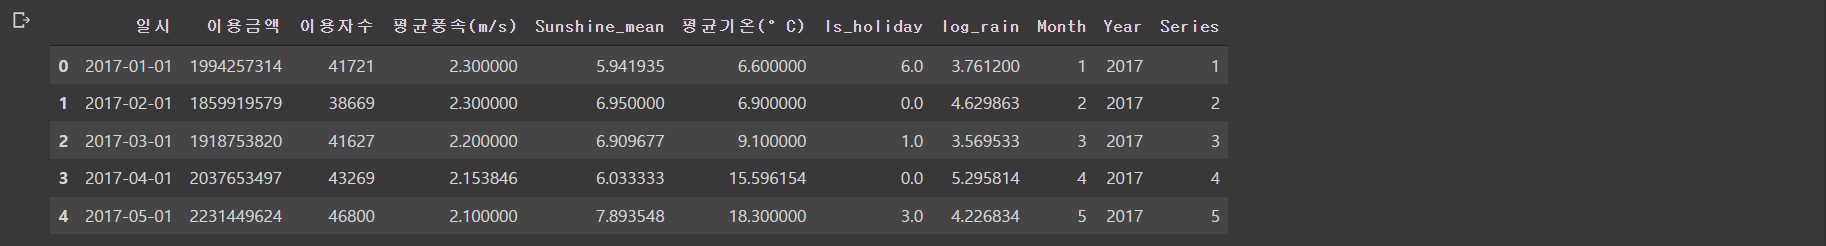

In [ ]:
# split data into train-test set
train = data[data['Series'] < 51]
test = data[data['Series'] >= 51]

# check shape
train.shape, test.shape

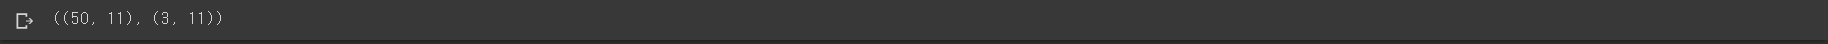

In [ ]:
# import the regression module
from pycaret.regression import *


# initialize setup
s = setup(data = train, 
          test_data = test, 
          target = '이용금액', 
          fold_strategy = 'timeseries', 
          numeric_features = ['이용자수', '평균풍속(m/s)','Sunshine_mean','평균기온(°C)','Is_holiday','log_rain','Year', 'Series'], 
          fold = 16, #kfold cross validation: test set overfitting 방지
          session_id = 1
          )

# pycaret recommand best model
best_mod_ = compare_models(n_select=3, sort='RMSE') #fold = 16

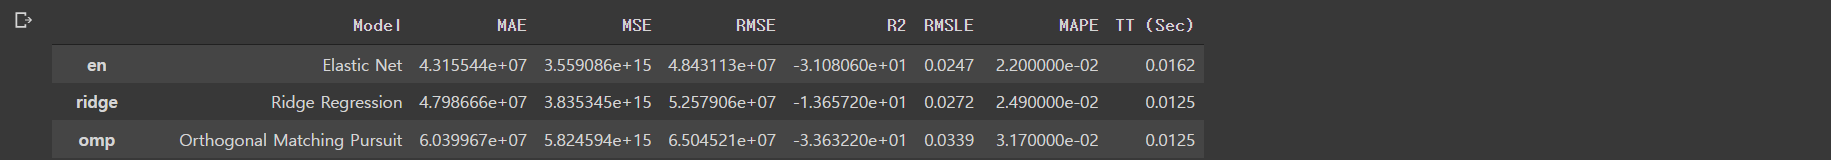

In [ ]:
# create model
en = create_model('en', fold=16)
tuned_en = tune_model(estimator=en, fold=16, optimize='rmse')
en_predictions_holdout = predict_model(tuned_en)

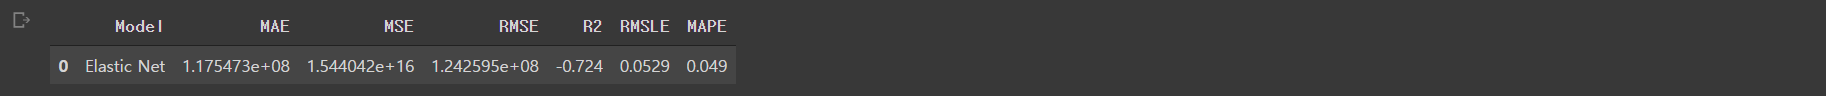

In [ ]:
# 생성한 모델로 test set 기간의 값 Prediction
testset_pred = predict_model(tuned_en)
testset_pred

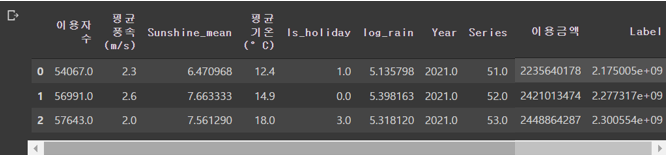

### 4. Ensemble (Using by Pycaret Library)

In [ ]:
# ML Ensemble

# Top 3 models blend
tuned_best_mod_top3 = [tune_model(i) for i in best_mod_]
blend_ = blend_models(estimator_list=tuned_best_mod_top3)

# generate predictions on the original dataset
predictions = predict_model(blend_, data=data)
# add a date column in the dataset
predictions['Date'] = pd.date_range(start='2017-01-01', end = '2021-05-01', freq = 'MS')

# line plot
fig = px.line(predictions, x='Date', y=["이용금액", "Label"])
# add a vertical rectange for test-set separation
fig.add_vrect(x0="2021-03-01", x1="2021-05-01", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

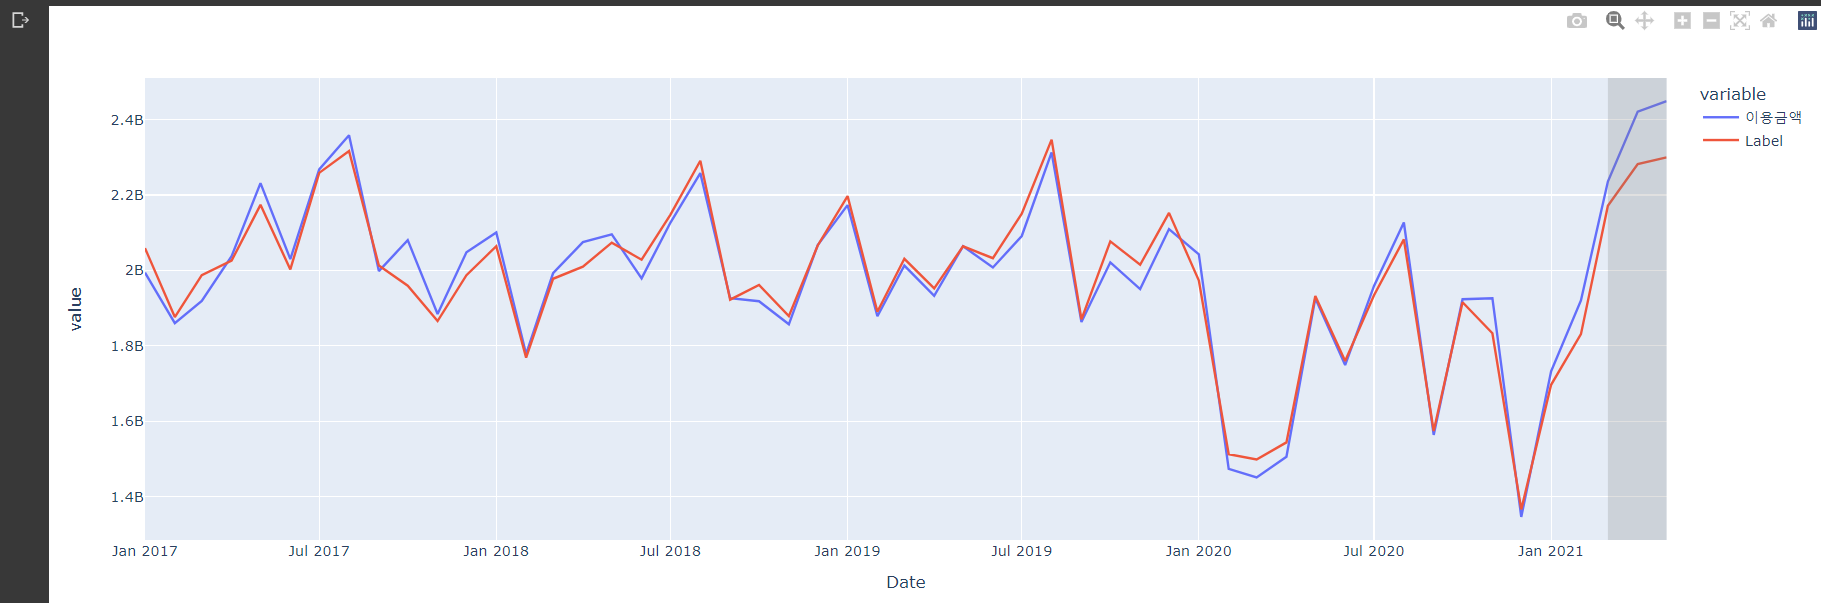

In [ ]:
# Ensemble 모델의 내역 확인
final_blend_mod = finalize_model(blend_)
final_blend_mod

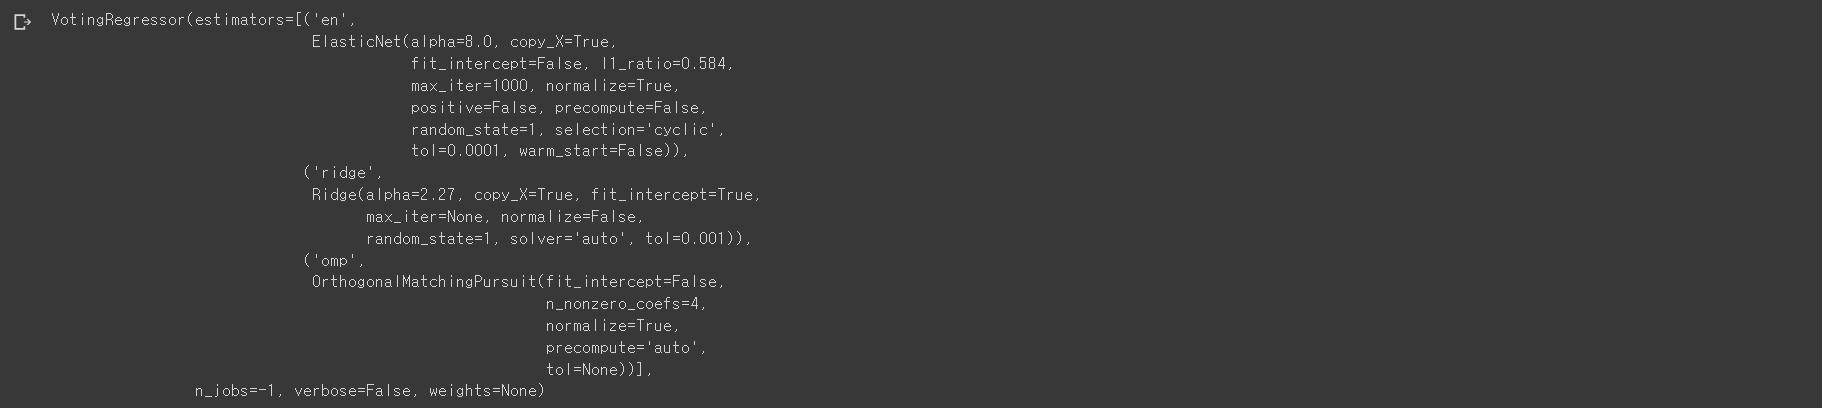

# End of the codes